# 1) Try creating a fully convolutional net with adaptive average pooling for MNIST (note that you’ll need fewer stride-2 layers). How does it compare to a network without such a pooling layer?

In [1]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

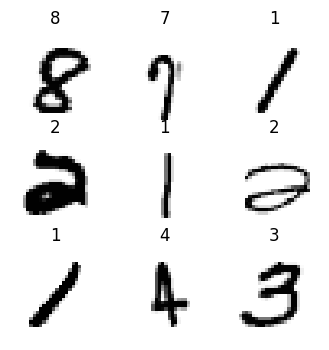

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()
dls.show_batch(max_n=9, figsize=(4,4))

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act:
        layers.append(nn.ReLU())

    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [ ]:
CNN = sequential(
        conv(1, 8, ks=5),        #14x14
        conv(8, 16),             #7x7
        conv(16, 32),            #4x4
        conv(32, 64),            #2x2
        conv(64, 10, act=False), #1x1
        Flatten())

In [ ]:
fCNN = sequential(
        conv(1, 8, ks=5),        #14x14
        conv(8, 16),             #7x7
        conv(16, 32),            #4x4
        nn.AdaptiveAvgPool2d(1), #1x1
        Flatten(),
        nn.Linear(32, dls.c))

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


SuggestedLRs(valley=0.004365158267319202)

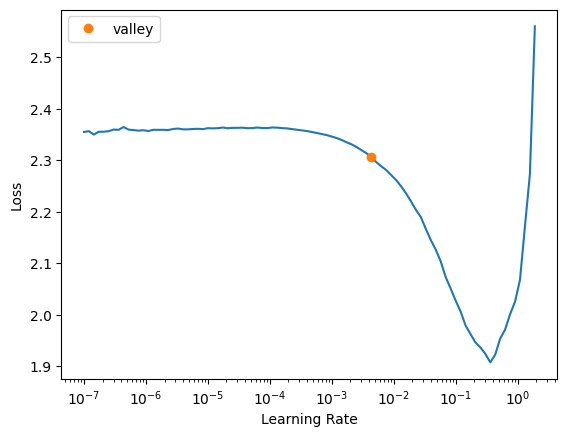

In [ ]:
# Pooling layer
learn = Learner(dls, fCNN, loss_func=F.cross_entropy, metrics=accuracy)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.205120,0.554228,0.844300,00:13
1,0.138048,0.166546,0.953500,00:12
2,0.114300,0.086453,0.973600,00:12
3,0.055971,0.050790,0.982900,00:12
4,0.034084,0.038890,0.987500,00:12


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


SuggestedLRs(valley=0.004365158267319202)

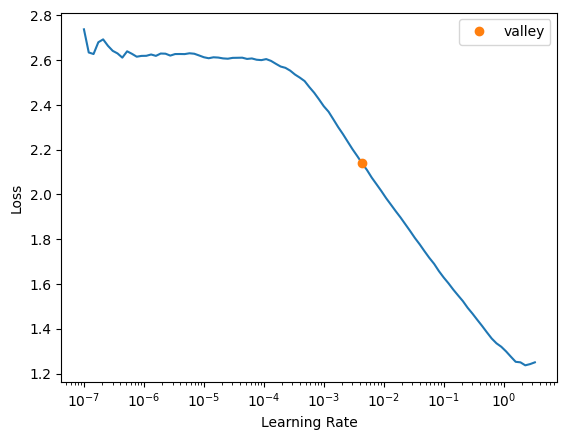

In [ ]:
# No pooling layer
learn = Learner(dls, CNN, loss_func=F.cross_entropy, metrics=accuracy)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.214529,0.223517,0.936100,00:13
1,0.171356,0.160991,0.949000,00:14
2,0.130241,0.110116,0.969200,00:14
3,0.072987,0.049079,0.984600,00:14
4,0.032720,0.024926,0.991200,00:14


As expected **CNN** performs **better** than **fCNN**, that is because you can’t decide, for instance, whether a number is a 3 or an 8 by *slicing* it into small pieces, *jumbling* them up, and deciding whether on average each piece looks like a 3 or an 8. But that’s what **adaptive average pooling effectively does!** Fully convolutional networks are really a good choice only for objects that don’t have a single correct orientation or size (e.g., like most natural photos). The difference isn't that much big because we are taking avg pool of a matrix that has already been reduced to 4x4 so we don't lose so much of an information.

# 2) In Chapter 17, we introduce Einstein summation notation. Skip ahead to see how this works, and then write an implementation of the 1×1 convolution operation using torch.einsum. Compare it to the same operation using torch.conv2d.

In [ ]:
path = untar_data(URLs.IMAGENETTE_160)
Path.BASE_PATH = path

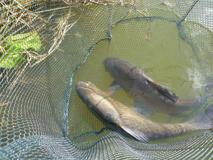

In [ ]:
img = PILImage.create(path/'train'/'n01440764'/'ILSVRC2012_val_00000293.JPEG')
img

In [ ]:
import torchvision.transforms as transforms

In [ ]:
tensor_img = transforms.ToTensor()(img).unsqueeze(0)
tensor_img.shape

torch.Size([1, 3, 160, 213])

In [ ]:
weight = torch.randn(3, 3, 1, 1)

In [ ]:
%%timeit
tconv = torch.conv2d(tensor_img, weight)

324 µs ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
tconv = torch.conv2d(tensor_img, weight)

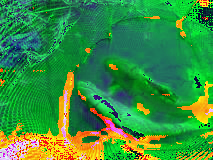

In [ ]:
transforms.ToPILImage()(tconv.squeeze(0))

In [ ]:
%%timeit
myconv = torch.einsum('chw,oc->ohw', tensor_img.squeeze(0), weight.squeeze(-1,-2))

67.5 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
myconv = torch.einsum('chw,oc->ohw', tensor_img.squeeze(0), weight.squeeze(-1,-2))

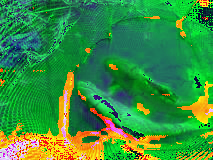

In [ ]:
transforms.ToPILImage()(myconv.squeeze(0))

**torch.conv2d** is faster on CPU, **torch.einsum** is faster on GPU, squeezing unit dimensions for torch.einsum is *benficial* - it makes the whole operation more *comprehensive* and it is a *little faster*. For GPU, squeezing dimensions slows down this operation.

# 3) Write a top-5 accuracy function using plain PyTorch or plain Python.

Python:

In [ ]:
def top_5_accuracy(preds, targets):
    score = 0
    for i in range(len(preds)):
        zip_preds = zip(preds[i], range(len(preds[i])))
        all_sorted = sorted(zip_preds, key=lambda x: x[0], reverse=True)
        top5 = all_sorted[:5]
        if targets[i] in [t[0] for t in top5]:
            score += 1
        else:
            pass

    return score/len(preds)

Pytorch:

In [ ]:
def top_5_accuracy(preds, targets):
    preds_tensor = torch.tensor(preds)
    targets_tensor = torch.tensor(targets)

    top5, _ = torch.topk(preds_tensor, k=5, dim=1)
    correct = torch.any(top5 == targets_tensor.view(-1, 1), dim=1)

    accuracy = torch.sum(correct).item() / len(preds)
    return accuracy

In [ ]:
# Example
import numpy as np

preds = np.array([
    [0.1, 0.5, 3, 0.8, 0.3, 5, 7, 8],
    [0.4, 0.3, 0.9, 3, 0.7, 5, 6, 2],
    [0.6, 0.1, 0.3, 3, 0.5, 0, 5, 3]
])

targets = np.array([3, 2, 0])

acc = top_5_accuracy(preds, targets)
print(f"Top-5 Accuracy: {acc:.4f}")


Top-5 Accuracy: 0.6667


# 4) Train a model on Imagenette for more epochs, with and without label smoothing. Take a look at the Imagenette leaderboards and see how close you can get to the best results shown. Read the linked pages describing the leading approaches.

In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [3]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=256)

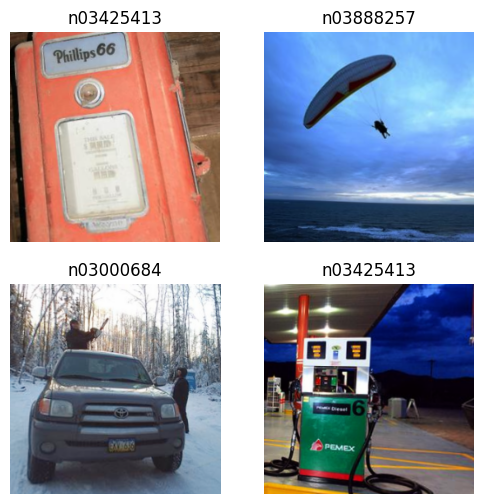

In [4]:
dls.show_batch(max_n=4)

In [5]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride),
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [6]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [7]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [8]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))

    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

In [9]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [ ]:
learn = Learner(dls, rn, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy, cbs=MixUp)

SuggestedLRs(valley=0.00013182566908653826)

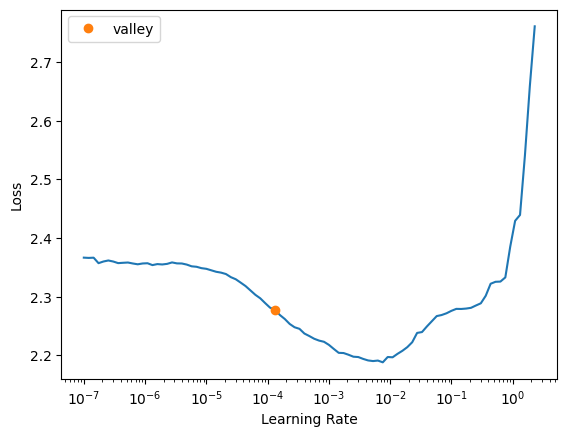

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(200, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.961078,1.923964,0.419108,00:24
1,1.829238,1.616195,0.550573,00:24
2,1.751514,1.545880,0.566369,00:24
3,1.689378,1.451192,0.617325,00:24
4,1.642236,1.446808,0.603567,00:24
5,1.614800,1.561691,0.599236,00:24
6,1.591219,1.583318,0.572484,00:24
7,1.561745,1.461731,0.610701,00:24
8,1.550711,1.389472,0.632866,00:24
9,1.536501,1.567609,0.557452,00:24


Without label smoothing and mixup

In [10]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [11]:
learn = Learner(dls, rn, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

SuggestedLRs(valley=0.00013182566908653826)

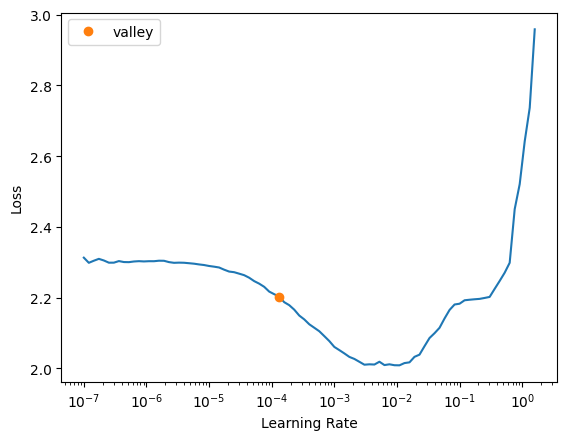

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(200, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.628451,1.523752,0.509554,00:24
1,1.393942,1.353731,0.569427,00:24
2,1.243206,1.182829,0.628790,00:24
3,1.147718,1.168517,0.639236,00:24
4,1.074259,1.278571,0.592866,00:24
5,1.006266,1.401842,0.559745,00:24
6,0.949543,1.383895,0.592866,00:24
7,0.902427,1.205498,0.596688,00:24
8,0.861100,1.036598,0.683312,00:24
9,0.841122,1.325450,0.610191,00:23


Mixup and label smoothing makes a clear difference